In [ ]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None #default empty function
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other) #all non value objects to be added
    out = Value(self.data + other.data, (self, other), '+')#self and other are children of the output value and they created it
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad #need to accumilate in case that self=other
    out._backward = _backward
    return out

  def __radd__(self, other):
    return self + other

  def __mul__(self, other):
      other = other if isinstance(other, Value) else Value(other)
      out = Value(self.data * other.data, (self, other), 'x')
      def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
      out._backward = _backward
      return out

  def __sub__(self, other):
    return self + other * -1.0

  def __rmul__(self, other):
    return self * other

  def tanh(self):
      x = self.data
      t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
      out = Value(t, (self, ), 'tanh')
      def _backward():
        self.grad += (1 - t**2) * out.grad
      out._backward = _backward
      return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp') #e^x
    def _backward(): #e^x
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float))
    out = Value(self.data**other, (self, ), f'**{other}') #self^other
    def _backward(): #d self^other/ d self = other * self**other-1
      self.grad += other * self.data**(other-1) * out.grad
    out._backward = _backward
    return out

  def __truediv__(self,other): #self/other
    return self * other**-1.0

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    topo
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [ ]:
#can only do addition amongst value objects issue
a = Value(4.0)
b = Value(2.0)
a - b

Value(data=2.0)

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

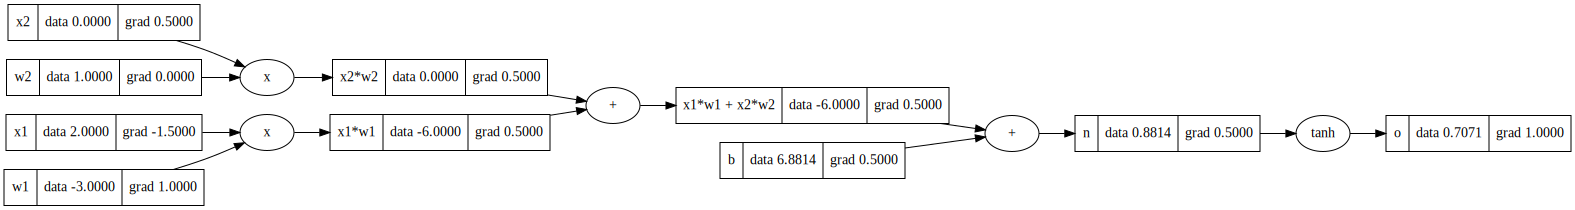

In [ ]:
draw_dot(o)

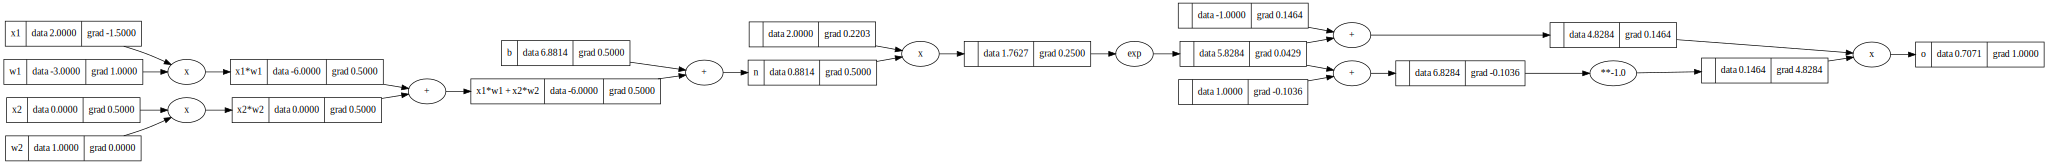

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
#---
e = (2*n).exp()
o = (e-1)/(e+1)
o.label = 'o'
#---
o.backward()
draw_dot(o)

In [ ]:
import torch
#tensor = n dimentional array of scalars
#cast all to double since default float notation in python is double
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
#pytorch assumes by default that leaf nodes dont require gradient for efficiency
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
#pytorch also has .data and .grad
print(o.data.item()) #.item takes a single tensor of one element and just gets that elem stripping out the tensor
#this prints forward pass
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
torch.Tensor([[1,2,3], [4,5,6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [ ]:
o.item() # = to o.data.item()

0.7071066904050358

In [ ]:
x2.grad.item()

0.5000001283844369

In [ ]:
#neural nets = class of mathematical expressions

class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] #weight =. random number btw -1 and 1
    self.b = Value(random.uniform(-1,1)) #bias control overall trigger happyness of neuron

  def __call__(self,x):
    #w * x + b where * is dot product
    #multiply all elems of w with all elems of x pairwise
    #zip(self.w, x) #takes two iterators and creates a new iterator to iterate through the touples
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) #raw activation
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b] #returns parameter scalars

x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.9266014139023941)

In [ ]:
class Layer: #layer is list of neurons

  def __init__(self, nin, nout): # input arguement of how many neurons we want in layer
  #single in out = # neurons in single layer
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
    # params = []
    # for neuron in self.neurons:
    #   ps = neuron.parameters()
    #   params.extend(ps)
    # return params

x = [2.0, 3.0]
n = Layer(2,3) #3 two dimentional neurons
n(x)

[Value(data=-0.7935013894268887),
 Value(data=0.12393096870960188),
 Value(data=0.3479374259892245)]

In [ ]:
class MLP: #list of in outs

  def __init__(self, nin, nouts): #list defines sizes of neurons we want in nlp
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] #iterate over pairs of sizes and create layers for them

  def __call__(self, x): #call layers sequentually
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


x = [2.0, 3.0, -1.0] #3 dim input
n = MLP(3,[4,4,1]) #3 input, 2 layers of 4 and 1 output
n(x)

Value(data=-0.20986969847059334)

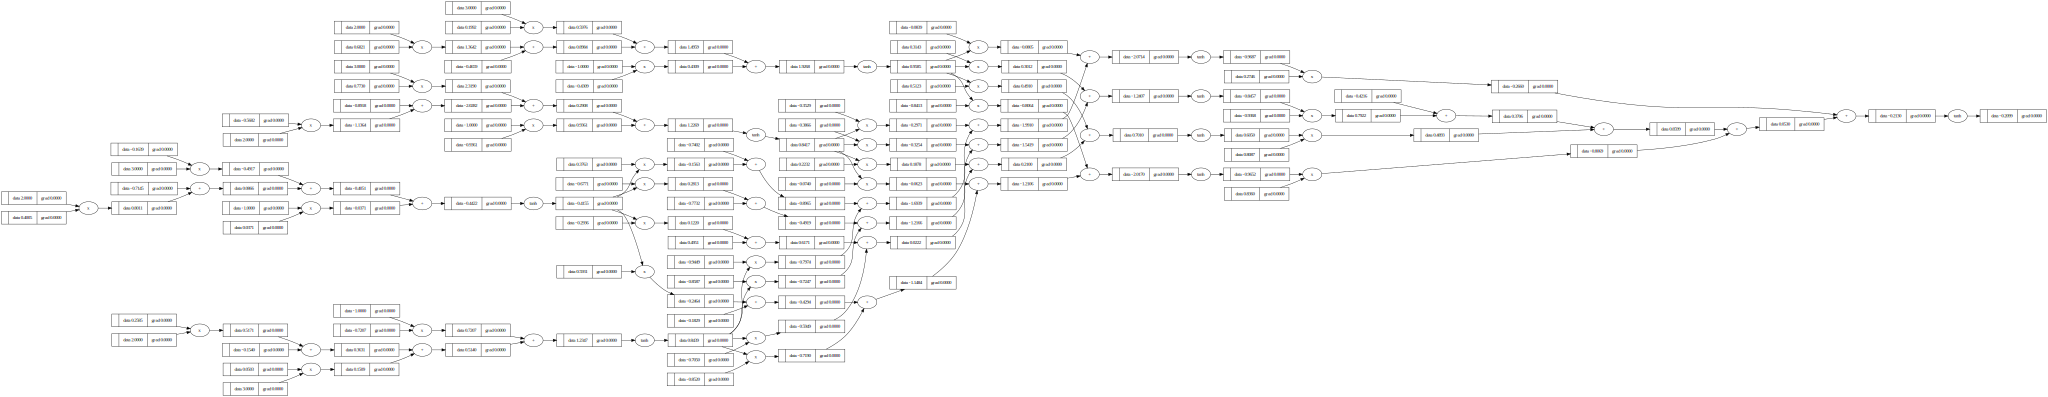

In [ ]:
draw_dot(n(x))

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets (binary classifier)
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.20986969847059334),
 Value(data=-0.14215613166517413),
 Value(data=0.0204061629562182),
 Value(data=-0.35292874216072456)]

In [ ]:
'''push first higher, second lower, third lower, fourth higher'''
#need to tune the weights
#done by calculating the loss (how well neural net is performing)
loss = [(yout - ygt)**2 for ygt,yout in zip(ys,ypred)]
loss #mse loss get zero when yout = ygt
total_loss = Value(0.0)
for num in loss:
  total_loss += num
total_loss #greater loss = worse prediction

Value(data=5.0713257084806145)

In [ ]:
total_loss.backward()

In [ ]:
n.layers[0].neurons[0].w[0].grad #influence of first layer's first neuron's first weight has this impact on the loss
#gradients of input data not that useful since they are fixed

2.10019514178565

In [ ]:
n.layers[0].neurons[0].w[0].data
#decreasing parameters increase the data since gradient is negative which should decrease the loss

0.400546095137823

In [ ]:
#want to collect all the params of nn to nudge them simultaneously in one array
#add parameters def to all the objects
n.parameters()
len(n.parameters())

41

In [ ]:
for p in n.parameters(): #update all parameters
  p.data += -0.1 * p.grad #learning rate 0.01

In [ ]:
n.layers[0].neurons[0].w[0].data #increased data


0.190526580959258

In [ ]:
ypred = [n(x) for x in xs]
loss = [(yout - ygt)**2 for ygt,yout in zip(ys,ypred)]
loss


[Value(data=0.015356870386491576),
 Value(data=1.5407899280231916),
 Value(data=0.07149877289020205),
 Value(data=0.025583558909352846)]

In [ ]:
total_loss = Value(0.0)
for num in loss:
  total_loss += num
total_loss #decreased loss
#predictions better match targets

Value(data=1.6532291302092381)

In [ ]:
total_loss.backward()
ypred
#gradient decent is just iterative forward pass, backward pass, and update params to make predictions match target better(seen through decreasing loss)

[Value(data=0.8760771595447733),
 Value(data=0.24128559486654472),
 Value(data=-0.7326074554326504),
 Value(data=0.8400513866601125)]

In [ ]:
n(x) #reimplement function

Value(data=0.8760771595447733)

In [ ]:
#implement all this in an actual training loop
for k in range(10):
  #forward pass
  ypred = [n(x) for x in xs]
  total_loss = sum([(yout - ygt)**2 for ygt,yout in zip(ys,ypred)])
  # total_loss = Value(0.0)
  # for num in loss:
  #   total_loss += num

  #backward pass
  for p in n.parameters():
    p.grad = 0.0
  total_loss.backward() #reset grads so backward pass solely accumilates the gradient

  #do update
  for p in n.parameters():
    p.data += -0.25 * p.grad

  print(k, total_loss.data)

0 1.6532291302092381
1 7.431837202348337
2 1.2933705478173296
3 0.0439600852723635
4 0.005893140452641369
5 0.0046674959919010385
6 0.0039025694367372413
7 0.0033727398019855197
8 0.0029810892525158708
9 0.0026782966189692024


In [ ]:
ypred

[Value(data=0.9990353456708329),
 Value(data=-0.9681226926786481),
 Value(data=-0.9592559552099852),
 Value(data=0.9989387963985286)]